## Import the necessary packages

In [1]:
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

/opt/homebrew/anaconda3/envs/env-2-rl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definition of the Actor and Critic classes

In [2]:
class Actor(nn.Module):
    def __init__(self, n_inputs, n_actions, hidden_size, learning_rate):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax(dim = 1)
        )
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        policy = self.network(state)
        return policy
    
    
class Critic(nn.Module):
    def __init__(self, n_inputs, hidden_size, learning_rate):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = self.network(state)

        return value

## Definition of the A2C agent

In [3]:
def advantage_actor_critic(env,max_epochs, max_episodes, hidden_size, learning_rate, gamma):
    n_inputs = env.observation_space.shape[0]
    n_outputs = env.action_space.n
    
    actor = Actor(n_inputs, n_outputs, hidden_size, learning_rate)
    critic = Critic(n_inputs, hidden_size, learning_rate)
    actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

    all_rewards = []
    total_entropy = 0

    for episode in range(max_episodes):
        log_probas = []
        values = []
        rewards = []

        state, _ = env.reset()
        for epoch in range(max_epochs):
            
            #Actor critic decision
            
            value = critic.forward(state).detach().numpy()[0,0]   
            policy =  actor.forward(state)
            policy_np = policy.detach().numpy() 
            action = np.random.choice(n_outputs, p=np.squeeze(policy_np))
            log_proba = torch.log(policy.squeeze(0)[action])
            entropy = -np.sum(np.mean(policy_np) * np.log(policy_np))
            
            #Action towards new state
            
            state, reward, done, _, _ = env.step(action)

            values.append(value)
            log_probas.append(log_proba)
            rewards.append(reward)            
            total_entropy += entropy
            
            if done or epoch == max_epochs-1:
                q_value = actor.forward(state).detach().numpy()[0,0]
                sum_rewards = np.sum(rewards)
                all_rewards.append(sum_rewards)

                if episode % 10 == 0:                    
                    print(f"Episode: {episode}, total reward: {sum_rewards}")  
                break
                
        #Computation of the loss
        values = torch.FloatTensor(values)
        q_values = []
        
        for reward in (rewards[::-1]):
            q_value = reward + gamma * q_value
            q_values.append(q_value)
            
        q_values = torch.FloatTensor(q_values[::-1])
        log_probas = torch.stack(log_probas)
        
        advantage = q_values -  values
        actor_loss = torch.mean(-log_probas * advantage)
        critic_loss = 1/2 * torch.mean(advantage**2)
        actor_critic_loss = actor_loss + critic_loss + 0.001 * total_entropy
        
        #Optimization step

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        actor_critic_loss.backward()
        
        actor_optimizer.step()
        critic_optimizer.step()
        
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()  
    return all_rewards, smoothed_rewards
    
    



## Parameters 

In [4]:
max_epochs = 300
max_episodes = 2000

hidden_size = 256
learning_rate = 0.0003
gamma = 0.99


## Train our agent in the CartPole environnment

In [6]:
env = gym.make("CartPole-v0")
rewards, smoothed_rewards = advantage_actor_critic(env,max_epochs, max_episodes, hidden_size, learning_rate, gamma)

Episode: 0, total reward: 11.0
Episode: 10, total reward: 10.0
Episode: 20, total reward: 10.0
Episode: 30, total reward: 15.0
Episode: 40, total reward: 13.0
Episode: 50, total reward: 17.0
Episode: 60, total reward: 12.0
Episode: 70, total reward: 16.0
Episode: 80, total reward: 12.0
Episode: 90, total reward: 13.0
Episode: 100, total reward: 24.0
Episode: 110, total reward: 18.0
Episode: 120, total reward: 12.0
Episode: 130, total reward: 11.0
Episode: 140, total reward: 14.0
Episode: 150, total reward: 14.0
Episode: 160, total reward: 12.0
Episode: 170, total reward: 13.0
Episode: 180, total reward: 15.0
Episode: 190, total reward: 18.0
Episode: 200, total reward: 15.0
Episode: 210, total reward: 19.0
Episode: 220, total reward: 18.0
Episode: 230, total reward: 22.0
Episode: 240, total reward: 26.0
Episode: 250, total reward: 10.0
Episode: 260, total reward: 12.0
Episode: 270, total reward: 9.0
Episode: 280, total reward: 12.0
Episode: 290, total reward: 25.0
Episode: 300, total re

## Results

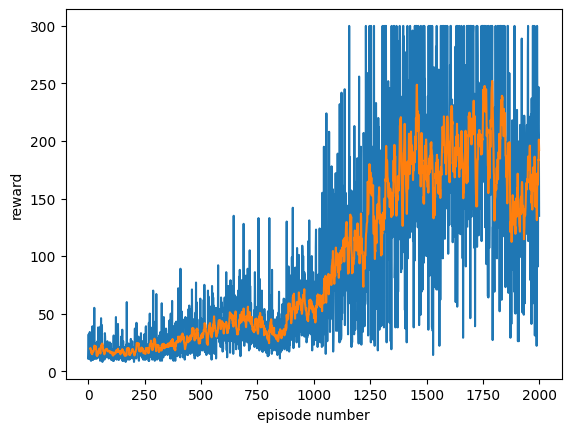

In [7]:
plt.plot(rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('episode number')
plt.ylabel('reward')
plt.show()